<a href="https://colab.research.google.com/github/susreetha/datascience/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie


Each video is a sequence of 30 frames (or images).

### Objectives



1.   **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
2.   **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.
3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [ ]:
!pip uninstall scipy
!pip install scipy==1.2.2


Found existing installation: scipy 1.2.2
Uninstalling scipy-1.2.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.2.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.2.2
  Using cached scipy-1.2.2-cp37-cp37m-manylinux1_x86_64.whl (24.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.



In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.



In [ ]:
#get the train and test dataset directories
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Gesture Recognition/Project_data'
train_doc = np.random.permutation(open(root_path + '/train.csv').readlines())
val_doc = np.random.permutation(open(root_path + '/val.csv').readlines())
batch_size = 32

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

In [ ]:
#import keras and tensorflow

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

#import cv2 and matplots for plotting
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
#abstract base class for model building
class ModelBuilder(metaclass= abc.ABCMeta):
    # constructor initializes path for the class
    def __init__(self):
        self.train_doc = train_doc
        self.val_doc = val_doc
        self.train_path = root_path + '/' + 'train'
        self.val_path =  root_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialize image dimensions
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialize hyper params: the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    #  generator function for preprocessing image data set
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
## function for plotting accuracy/loss
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Sample Model - Conv3D Model


In [ ]:
class ModelConv3DBase(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        model.compile(optimizer = 'adam',
                      loss = 'categorical_crossentropy',
                      metrics = ['categorical_accuracy'])
        return model


#### Model 1 - 30 Frames , batch size 10 & 1 epoch


In [ ]:
conv_3d_model1 = ModelConv3DBase()
conv_3d_model1.initialize_image_properties(image_height=160, image_width=160)
conv_3d_model1.initialize_hyperparams(frames_to_sample=30, batch_size=10, num_epochs=1)
conv_3d_model1 = conv_3d_model1.define_model()
conv_3d_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

### Sample cropping

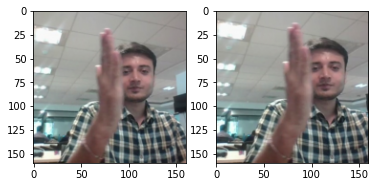

In [ ]:
test_generator = ModelConv3DBase()
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g = test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

### Try other models with different hyperparams

In [ ]:
conv_3d_model1 = ModelConv3DBase()
conv_3d_model1.initialize_image_properties(image_height=160, image_width=160)
conv_3d_model1.initialize_hyperparams(frames_to_sample=30, batch_size=40, num_epochs=2)
conv_3d_model1 = conv_3d_model1.define_model()
conv_3d_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
conv_3d_model1 = ModelConv3DBase()
conv_3d_model1.initialize_image_properties(image_height=160, image_width=160)
conv_3d_model1.initialize_hyperparams(frames_to_sample=20, batch_size=40, num_epochs=2)
conv_3d_model1 = conv_3d_model1.define_model()
conv_3d_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [ ]:
conv_3d_model1 = ModelConv3DBase()
conv_3d_model1.initialize_image_properties(image_height=200, image_width=200)
conv_3d_model1.initialize_hyperparams(frames_to_sample=20, batch_size=40, num_epochs=2)
conv_3d_model1 = conv_3d_model1.define_model()
conv_3d_model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 200, 200, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 200, 200, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 200, 200, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 100, 100, 16)  0        
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 100, 100, 32)  13856     
                                                                 
 activation_13 (Activation)  (None, 10, 100, 100, 32) 

In [ ]:
conv_3d_model1 = ModelConv3DBase()
conv_3d_model1.initialize_image_properties(image_height=200, image_width=200)
conv_3d_model1.initialize_hyperparams(frames_to_sample=16, batch_size=40, num_epochs=2)
conv_3d_model1 = conv_3d_model1.define_model()
conv_3d_model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 200, 200, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 200, 200, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 200, 200, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 100, 100, 16)  0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 100, 100, 32)   13856     
                                                                 
 activation_17 (Activation)  (None, 8, 100, 100, 32)  

From the above models it is clear that image resolution ( width X height) has the most impact on model training then followed by number of frames

### Model with - 20 Frames , batch size 40 & 15 epochs

In [ ]:
conv_3d_model2_cls = ModelConv3DBase()
conv_3d_model2_cls.initialize_image_properties(image_height=160, image_width=160)
conv_3d_model2_cls.initialize_hyperparams(frames_to_sample=20, batch_size=40, num_epochs=15)
conv_3d_model2 = conv_3d_model2_cls.define_model()
conv_3d_model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d_model2.count_params())
history_model1 = conv_3d_model2_cls.train_model(conv_3d_model2)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5462 - categorical_accuracy: 0.4103  
Epoch 1: val_loss improved from inf to 2.27463, saving model to model_init_2022-03-1618_11_49.071111/model-00001-1.54619-0.41026-2.27463-0.16000.h5
17/17 [==============================] - 2908s 181s/step - loss: 1.5462 - categorical_accuracy: 0.4103 - val_loss: 2.2746 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.8737 - categorical_accuracy: 0.6606
Epoch 2: val_loss did not improve from 2.27463
17/17 [==============================] - 71s 4s/step - loss: 0.8737 - categorical_accuracy: 0.6606 - val_loss: 2.5479 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6662 - categorical_accuracy: 0.7572
Epoch 3: val_loss did not improve from 2.27463
17/17 [==============================] - 75s 5s/step - loss: 0.6662 - categorica

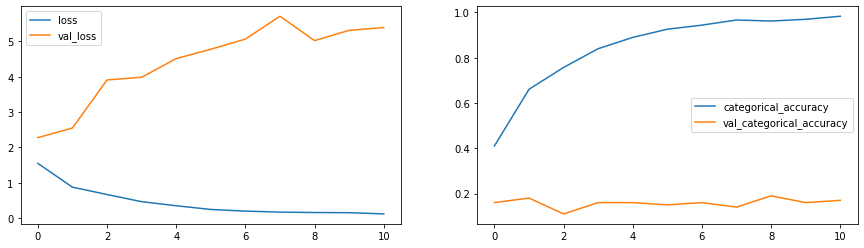

In [ ]:
plot(history_model1)


**Analyzing Learning curves**
A plot of learning curves shows overfitting:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss is increasing .
- Also the validation accuracy is low - 17%
- Training accuracy is 98%
The learning curve shows overfitting

## Model 2
Use Model with updated hyperparams
Adding dropout layers - Batch Size = 20 and No. of Epochs = 25


In [ ]:
conv_3d_model2_cls = ModelConv3DBase()
conv_3d_model2_cls.initialize_image_properties(image_height=160, image_width=160)
conv_3d_model2_cls.initialize_hyperparams(frames_to_sample=20, batch_size=20, num_epochs=25)
conv_3d_model2 = conv_3d_model2_cls.define_model(dense_neurons=256,dropout=0.5)
conv_3d_model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_25 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d_model2.count_params())
history_model2 = conv_3d_model2_cls.train_model(conv_3d_model2)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9840 - categorical_accuracy: 0.3635
Epoch 1: val_loss improved from inf to 4.98114, saving model to model_init_2022-03-1619_12_45.274704/model-00001-1.98397-0.36350-4.98114-0.21000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.9840 - categorical_accuracy: 0.3635 - val_loss: 4.9811 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3865 - categorical_accuracy: 0.5143
Epoch 2: val_loss did not improve from 4.98114
34/34 [==============================] - 70s 2s/step - loss: 1.3865 - categorical_accuracy: 0.5143 - val_loss: 6.2147 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9819 - categorical_accuracy: 0.6440
Epoch 3: val_loss did not improve from 4.98114
34/34 [==============================] - 70s 2s/step - loss: 0.9819 - categorical_accu

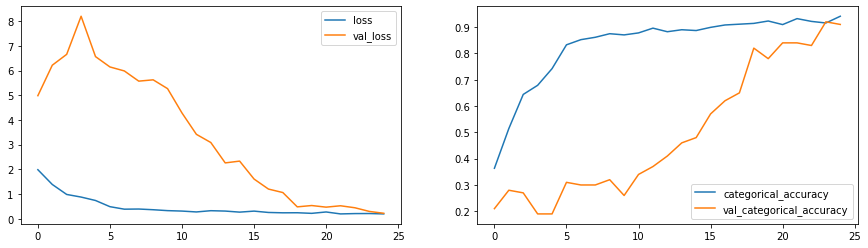

In [ ]:
plot(history_model2)


Analysing the visualization for second model ,
- Validation loss has decreased greatly to 3%, it decreased with experience
- Training loss is decreasing with experience
- Validation accuracy is 91% and training accuracy is close to 94%



## Model 3
Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [ ]:
from tensorflow.keras.optimizers import Adam
class ModelConv3DType3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_model3_cls = ModelConv3DType3()
conv_3d_model3_cls.initialize_image_properties(image_height=120, image_width=120)
conv_3d_model3_cls.initialize_hyperparams(frames_to_sample=16, batch_size=30, num_epochs=25)
conv_3d_model3 = conv_3d_model3_cls.define_model(filtersize=(2,2,2), dense_neurons=256,dropout=0.5)
conv_3d_model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d_model3.count_params())
history_model3 = conv_3d_model3_cls.train_model(conv_3d_model3)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.7417 - categorical_accuracy: 0.4374 
Epoch 1: val_loss improved from inf to 2.97613, saving model to model_init_2022-03-1619_41_47.316824/model-00001-1.74169-0.43741-2.97613-0.16000.h5
23/23 [==============================] - 951s 43s/step - loss: 1.7417 - categorical_accuracy: 0.4374 - val_loss: 2.9761 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.0397 - categorical_accuracy: 0.6063
Epoch 2: val_loss did not improve from 2.97613
23/23 [==============================] - 50s 2s/step - loss: 1.0397 - categorical_accuracy: 0.6063 - val_loss: 4.2445 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
22/23 [===========================>..] - ETA: 1s - loss: 0.8449 - categorical_accuracy: 0.6803
Epoch 3: val_loss did not improve from 2.97613
23/23 [==============================] - 52s 2s/step - loss: 0.8554 - categorical_a

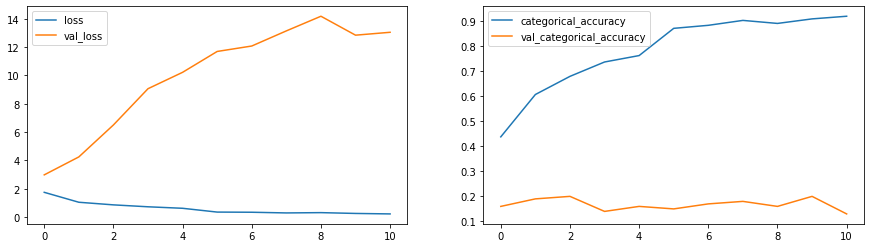

In [ ]:
plot(history_model3)


Analysing the visualization for second model ,

- Validation loss has increased
- Training loss is decreasing with experience
- Validation accuracy decreased to 13% and training accuracy decreased to 91.8%
The model is overfitting

## Model 4

Add more layers and drop out

In [ ]:
class ModelConv3DType4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_model4_cls = ModelConv3DType4()
conv_3d_model4_cls.initialize_image_properties(image_height=100, image_width=100)
conv_3d_model4_cls.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=15)
conv_3d_model4 = conv_3d_model4_cls.define_model(filtersize=(3,3,3), dense_neurons=128,dropout=0.25)
conv_3d_model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 16, 100, 100, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d_model4.count_params())
history_model4 = conv_3d_model4_cls.train_model(conv_3d_model4)

Total Params: 1489653
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7196 - categorical_accuracy: 0.3846
Epoch 1: val_loss improved from inf to 1.70764, saving model to model_init_2022-03-1620_06_46.919333/model-00001-1.71964-0.38462-1.70764-0.17000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.7196 - categorical_accuracy: 0.3846 - val_loss: 1.7076 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3399 - categorical_accuracy: 0.4630
Epoch 2: val_loss did not improve from 1.70764
34/34 [==============================] - 52s 2s/step - loss: 1.3399 - categorical_accuracy: 0.4630 - val_loss: 2.3253 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.9109 - categorical_accuracy: 0.6395
Epoch 3: val_loss did not improve from 1.70764
34/34 [==============================] - 52s 2s/step - loss: 0.9109 - categorical_accu

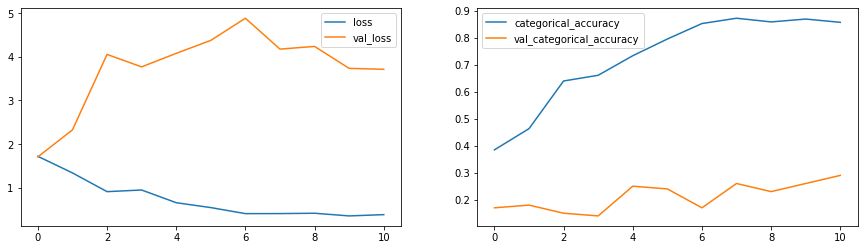

In [ ]:
plot(history_model4)


Analysing the visualization

- validation loss has decreased well than the previous model
- training accuracy has decreased only slightly
- validation accuracy increased a little to 41% better than model 3 and training accuracy slightly decreased to 87.9%

## Model 5

Reducing the number of parameters

In [ ]:
class ModelConv3DType5(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_model5_cls = ModelConv3DType5()
conv_3d_model5_cls.initialize_image_properties(image_height=100, image_width=100)
conv_3d_model5_cls.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=15)
conv_3d_model5 = conv_3d_model5_cls.define_model(dense_neurons=64,dropout=0.25)
conv_3d_model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_41 (Activation)  (None, 8, 50, 50, 32)    

In [ ]:
print("Total Params:", conv_3d_model5.count_params())
history_model5 = conv_3d_model5_cls.train_model(conv_3d_model5)

Total Params: 398213
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8234 - categorical_accuracy: 0.3439
Epoch 1: val_loss improved from inf to 1.98473, saving model to model_init_2022-03-1620_16_16.731530/model-00001-1.82336-0.34389-1.98473-0.21000.h5
34/34 [==============================] - 52s 2s/step - loss: 1.8234 - categorical_accuracy: 0.3439 - val_loss: 1.9847 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.1777 - categorical_accuracy: 0.5566
Epoch 2: val_loss did not improve from 1.98473
34/34 [==============================] - 51s 2s/step - loss: 1.1777 - categorical_accuracy: 0.5566 - val_loss: 2.7062 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.8522 - categorical_accuracy: 0.6923
Epoch 3: val_loss did not improve from 1.98473
34/34 [==============================] - 50s 2s/step - loss: 0.8522 - categoric

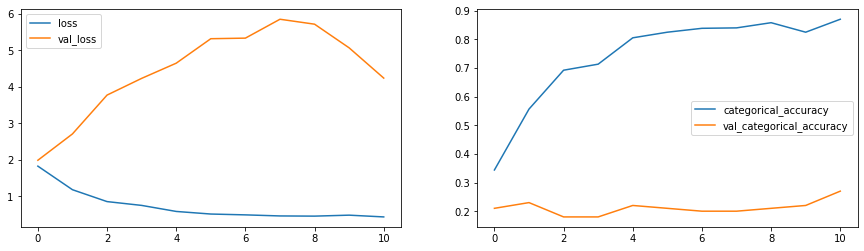

In [ ]:
plot(history_model5)


Analysing Visualization
- With lesser params the validation loss increased slightly
-  the validation accuracy decreased to 27%
- training accuracy is same and is around 87%

## Model 6 - CNN- LSTM Model


In [ ]:
class CNNLSTMModel(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
cnn_lstm = CNNLSTMModel()
cnn_lstm.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_lstm_model = cnn_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_54 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 18, 60, 60, 32) 

In [ ]:
print("Total Params:", cnn_lstm_model.count_params())
history_model6 = cnn_lstm.train_model(cnn_lstm_model,augment_data=True)

Total Params: 1266789
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.2690 - categorical_accuracy: 0.4563
Epoch 1: val_loss improved from inf to 1.89606, saving model to model_init_2022-03-1620_54_50.906745/model-00001-1.26902-0.45626-1.89606-0.21000.h5
34/34 [==============================] - 101s 3s/step - loss: 1.2690 - categorical_accuracy: 0.4563 - val_loss: 1.8961 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9263 - categorical_accuracy: 0.6463
Epoch 2: val_loss did not improve from 1.89606
34/34 [==============================] - 96s 3s/step - loss: 0.9263 - categorical_accuracy: 0.6463 - val_loss: 2.1096 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7892 - categorical_accuracy: 0.7097
Epoch 3: val_loss did not improve from 1.89606
34/34 [==============================] - 95s 3s/step - loss: 0.7892 - categorical_acc

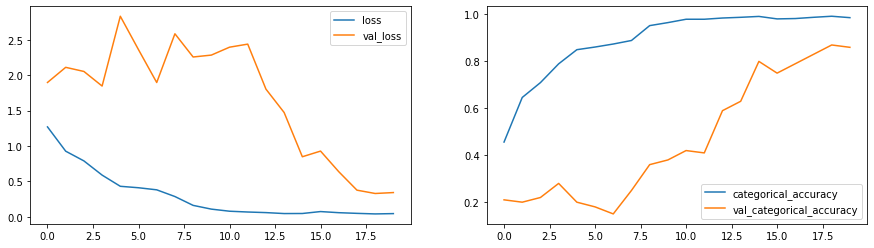

In [ ]:
plot(history_model6)
